<a href="https://colab.research.google.com/github/codehvb/Deep-Learning-Applications-Projects/blob/main/DV_A00046242.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ============================================================
# 0) Imports + basic setup
# ============================================================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you don't have statsmodels locally, install it (Colab usually has it)
# !pip -q install statsmodels
from statsmodels.tsa.seasonal import STL

plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_columns", 200)


In [12]:
# ============================================================
# 1) Load data (important: keep CSV + notebook/script in same folder for final submission)
# ============================================================
DATA_PATH = "./European_Airport_Traffic.csv"

def load_raw(path: str) -> pd.DataFrame:
    # I want this to fail loudly if the CSV isn't where it should be
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Can't find {path}. For submission, the CSV must be in the SAME folder as the .ipynb/.py"
        )
    return pd.read_csv(path)

raw = load_raw(DATA_PATH)
print("Raw shape:", raw.shape)
raw.head()


Raw shape: (40104, 23)


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,tra_cov,Transport coverage,schedule,Type of schedule,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_BRD,Passengers on board,INTL,International transport,TOT,Total,AT,Austria,2020-01,NaN,2528076,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_BRD,Passengers on board,INTL,International transport,TOT,Total,AT,Austria,2020-02,NaN,2496524,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_BRD,Passengers on board,INTL,International transport,TOT,Total,AT,Austria,2020-03,NaN,993708,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_BRD,Passengers on board,INTL,International transport,TOT,Total,AT,Austria,2020-04,NaN,12978,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_BRD,Passengers on board,INTL,International transport,TOT,Total,AT,Austria,2020-05,NaN,21487,NaN,NaN,NaN,NaN,NaN


In [13]:
# ============================================================
# 2) Keep only the columns I need + parse dates + make values numeric
# ============================================================
REQUIRED_COLS = [
    "freq", "unit", "tra_meas", "tra_cov", "schedule", "geo",
    "TIME_PERIOD", "OBS_VALUE", "OBS_FLAG", "CONF_STATUS"
]
missing = [c for c in REQUIRED_COLS if c not in raw.columns]
if missing:
    raise ValueError(f"Unexpected dataset structure. Missing: {missing}")

df = raw[REQUIRED_COLS].copy()

# TIME_PERIOD is like '2021-07', so I convert it into a real datetime for plotting & time analysis
df["date"] = pd.to_datetime(df["TIME_PERIOD"], format="%Y-%m")

# Passenger counts need to be numeric; anything weird becomes NaN (I’ll handle it carefully later)
df["value"] = pd.to_numeric(df["OBS_VALUE"], errors="coerce")

# Flags are useful for limitations later, so I keep them as clean strings
df["obs_flag"] = df["OBS_FLAG"].fillna("").astype(str).str.strip()
df["conf_flag"] = df["CONF_STATUS"].fillna("").astype(str).str.strip()

print("Value missing %:", round(df["value"].isna().mean() * 100, 2))
print("Date range:", df["date"].min().date(), "->", df["date"].max().date())
print("Unique geo codes:", df["geo"].nunique())
df.head()


Value missing %: 0.0
Date range: 2020-01-01 -> 2025-07-01
Unique geo codes: 39


,freq,unit,tra_meas,tra_cov,schedule,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS,date,value,obs_flag,conf_flag
0,M,PAS,PAS_BRD,INTL,TOT,AT,2020-01,2528076,NaN,NaN,2020-01-01,2528076,,
1,M,PAS,PAS_BRD,INTL,TOT,AT,2020-02,2496524,NaN,NaN,2020-02-01,2496524,,
2,M,PAS,PAS_BRD,INTL,TOT,AT,2020-03,993708,NaN,NaN,2020-03-01,993708,,
3,M,PAS,PAS_BRD,INTL,TOT,AT,2020-04,12978,NaN,NaN,2020-04-01,12978,,
4,M,PAS,PAS_BRD,INTL,TOT,AT,2020-05,21487,NaN,NaN,2020-05-01,21487,,


In [14]:
# ============================================================
# 3) Remove non-country aggregates (very important for fair country comparisons)
# ============================================================
# Some 'geo' entries are aggregates like EU_27_2020 (not a country).
# For country-level rankings, these would distort the results, so I exclude them.
NON_COUNTRY_GEOS = {
    "EU_27_2020", "EU27_2020", "EU28", "EA19", "EA20",
    # Sometimes datasets also include these; safe to exclude if present
    "EU", "EA", "EFTA", "EEA"
}

df = df[~df["geo"].isin(NON_COUNTRY_GEOS)].copy()
print("After removing aggregates, unique geo codes:", df["geo"].nunique())


After removing aggregates, unique geo codes: 37


In [15]:
# ============================================================
# 4) Map ISO codes to full country names (so plots look professional)
# ============================================================
COUNTRY_NAMES = {
    "AT": "Austria",
    "BE": "Belgium",
    "BG": "Bulgaria",
    "CY": "Cyprus",
    "CZ": "Czechia",
    "DE": "Germany",
    "DK": "Denmark",
    "EE": "Estonia",
    "EL": "Greece",
    "ES": "Spain",
    "FI": "Finland",
    "FR": "France",
    "HR": "Croatia",
    "HU": "Hungary",
    "IE": "Ireland",
    "IS": "Iceland",
    "IT": "Italy",
    "LT": "Lithuania",
    "LU": "Luxembourg",
    "LV": "Latvia",
    "MT": "Malta",
    "NL": "Netherlands",
    "NO": "Norway",
    "PL": "Poland",
    "PT": "Portugal",
    "RO": "Romania",
    "RS": "Serbia",
    "SE": "Sweden",
    "SI": "Slovenia",
    "SK": "Slovakia",
    "ME": "Montenegro",
    "MK": "North Macedonia",
    "AL": "Albania",
    "BA": "Bosnia and Herzegovina",
    # Add more if you see more codes in your dataset
}

df["country"] = df["geo"].map(COUNTRY_NAMES).fillna(df["geo"])
df[["geo", "country"]].drop_duplicates().head(12)


,geo,country
0,AT,Austria
66,BA,Bosnia and Herzegovina
102,BE,Belgium
167,BG,Bulgaria
231,CH,CH
294,CY,Cyprus
361,CZ,Czechia
423,DE,Germany
486,DK,Denmark
551,EE,Estonia


In [16]:
# ============================================================
# 5) Create analysis subset (passenger measures only)
# ============================================================
KEEP_MEAS = [
    "PAS_CRD", "PAS_CRD_ARR", "PAS_CRD_DEP",
    "PAS_BRD", "PAS_BRD_ARR", "PAS_BRD_DEP"
]
analysis = df[df["tra_meas"].isin(KEEP_MEAS)].copy()

# I keep a simple marker for confidentiality in case I want to discuss limitations
analysis["is_confidential"] = analysis["conf_flag"].ne("")

print("Analysis shape:", analysis.shape)
analysis.head()


Analysis shape: (38970, 16)


,freq,unit,tra_meas,tra_cov,schedule,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS,date,value,obs_flag,conf_flag,country,is_confidential
0,M,PAS,PAS_BRD,INTL,TOT,AT,2020-01,2528076,NaN,NaN,2020-01-01,2528076,,,Austria,False
1,M,PAS,PAS_BRD,INTL,TOT,AT,2020-02,2496524,NaN,NaN,2020-02-01,2496524,,,Austria,False
2,M,PAS,PAS_BRD,INTL,TOT,AT,2020-03,993708,NaN,NaN,2020-03-01,993708,,,Austria,False
3,M,PAS,PAS_BRD,INTL,TOT,AT,2020-04,12978,NaN,NaN,2020-04-01,12978,,,Austria,False
4,M,PAS,PAS_BRD,INTL,TOT,AT,2020-05,21487,NaN,NaN,2020-05-01,21487,,,Austria,False


In [17]:
# ============================================================
# 6) EDA helpers (quick sanity summaries)
# ============================================================
def missingness_report(d: pd.DataFrame) -> pd.DataFrame:
    out = (d.isna().mean().sort_values(ascending=False) * 100).to_frame("missing_%")
    out["missing_count"] = d.isna().sum()
    return out

def basic_value_checks(d: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "rows": [len(d)],
        "value_na": [d["value"].isna().sum()],
        "flagged_obs": [(d["obs_flag"] != "").sum()],
        "flagged_conf": [(d["conf_flag"] != "").sum()],
        "negatives": [(d["value"] < 0).sum()],
        "zeros": [(d["value"] == 0).sum()],
    })

display(missingness_report(analysis).head(10))
display(basic_value_checks(analysis))


,missing_%,missing_count
CONF_STATUS,100.0,38970
OBS_FLAG,100.0,38970
freq,0.0,0
unit,0.0,0
schedule,0.0,0
geo,0.0,0
tra_meas,0.0,0
tra_cov,0.0,0
OBS_VALUE,0.0,0
TIME_PERIOD,0.0,0


,rows,value_na,flagged_obs,flagged_conf,negatives,zeros
0,38970,0,0,0,0,2835


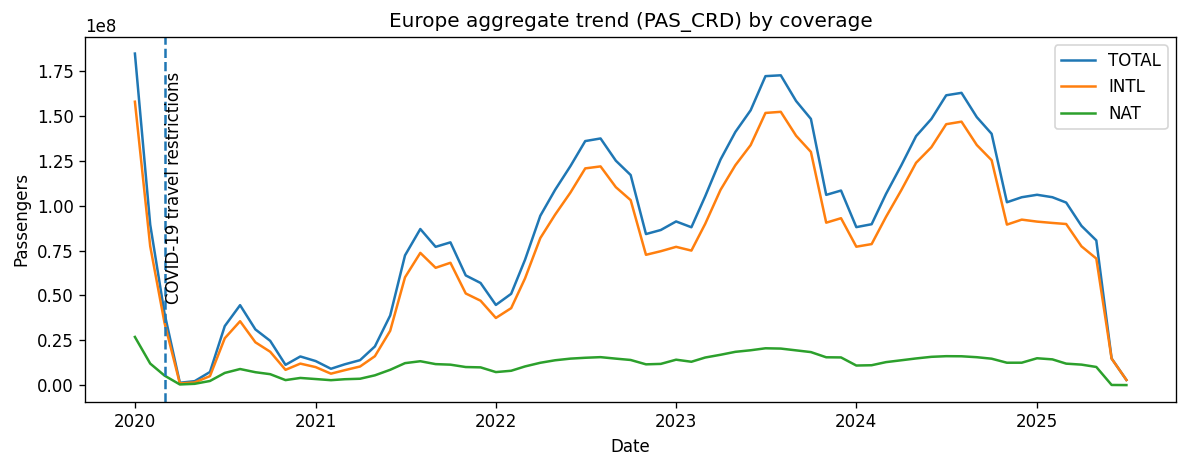

In [19]:
# ============================================================
# 7) EDA Visual 1: Europe aggregate trend (TOTAL vs INTL vs NAT)
# ============================================================
# ============================================================
# 7) EDA Visual 1: Europe aggregate trend (TOTAL vs INTL vs NAT)
# ============================================================
def plot_europe_trend(d: pd.DataFrame, meas="PAS_CRD"):
    tmp = (
        d[(d["tra_meas"] == meas) & (d["tra_cov"].isin(["TOTAL", "INTL", "NAT"]))]
        .groupby(["date", "tra_cov"], as_index=False)["value"].sum()
        .sort_values("date")
    )

    plt.figure(figsize=(10, 4))
    for cov in ["TOTAL", "INTL", "NAT"]:
        s = tmp[tmp["tra_cov"] == cov]
        plt.plot(s["date"], s["value"], label=cov)

    # --- COVID-19 context marker ---
    plt.axvline(pd.to_datetime("2020-03-01"), linestyle="--")
    plt.text(
        pd.to_datetime("2020-03-01"),
        plt.ylim()[1] * 0.9,
        "COVID-19 travel restrictions",
        rotation=90,
        va="top"
    )
    # --------------------------------

    plt.title(f"Europe aggregate trend ({meas}) by coverage")
    plt.xlabel("Year")
    plt.ylabel("Passengers")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_europe_trend(analysis, meas="PAS_CRD")


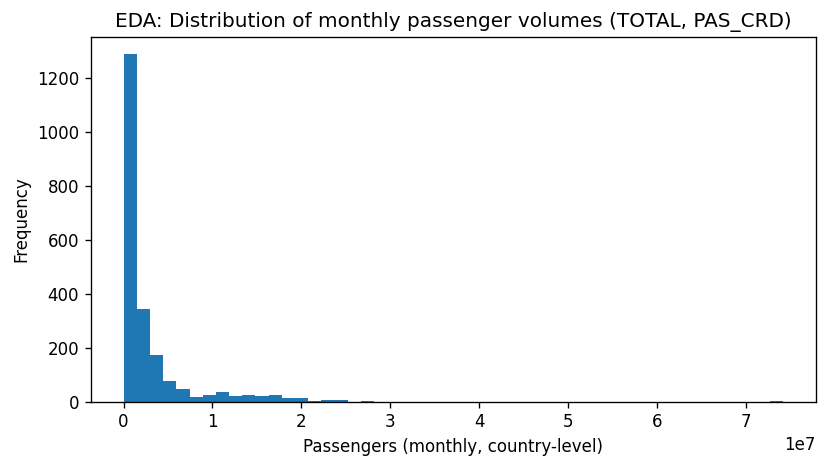

In [20]:
# ============================================================
# 8) EDA Visual 2: Distribution of monthly passenger volumes (helps justify skew/outliers)
# ============================================================
tmp_total = analysis[(analysis["tra_meas"] == "PAS_CRD") & (analysis["tra_cov"] == "TOTAL")].copy()

plt.figure(figsize=(7, 4))
plt.hist(tmp_total["value"].dropna(), bins=50)
plt.title("EDA: Distribution of monthly passenger volumes (TOTAL, PAS_CRD)")
plt.xlabel("Passengers (monthly, country-level)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


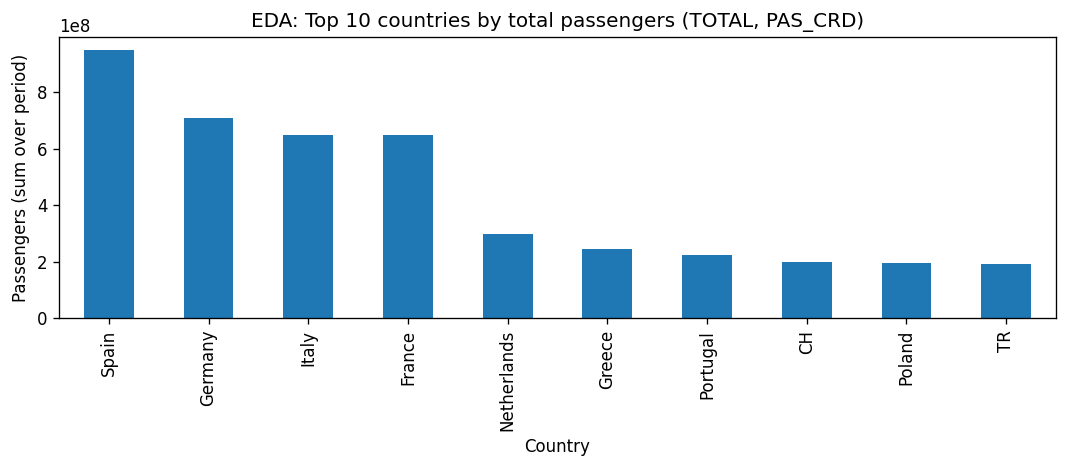

In [21]:
# ============================================================
# 9) EDA Visual 3: Top 10 countries by total passengers (2020–2025)
# ============================================================
top10 = (
    tmp_total.groupby("country")["value"].sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(9, 4))
top10.plot(kind="bar")
plt.title("EDA: Top 10 countries by total passengers (TOTAL, PAS_CRD)")
plt.xlabel("Country")
plt.ylabel("Passengers (sum over period)")
plt.tight_layout()
plt.show()


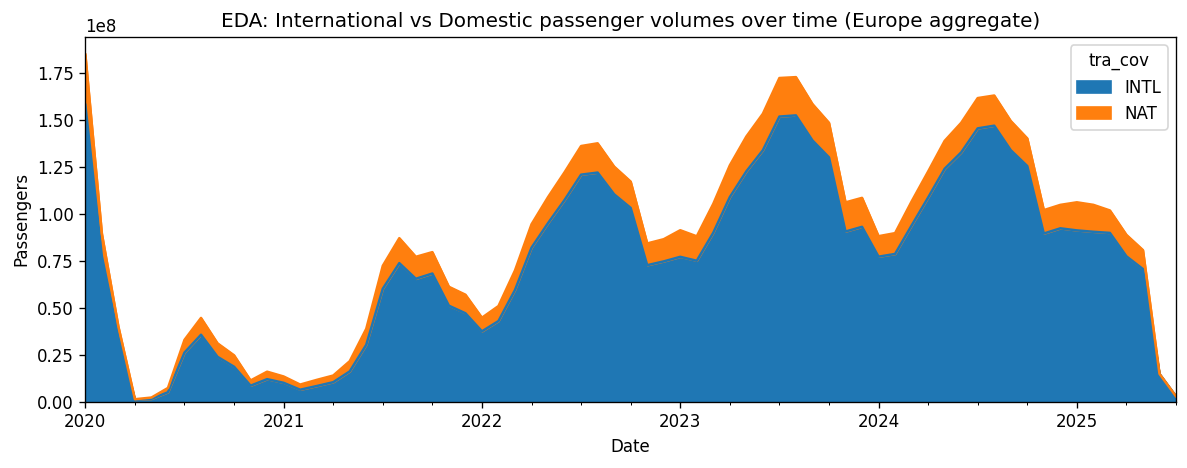

In [22]:
# ============================================================
# 10) EDA Visual 4: International vs Domestic share over time (stacked area)
# ============================================================
share = (
    analysis[analysis["tra_meas"] == "PAS_CRD"]
    .groupby(["date", "tra_cov"])["value"].sum()
    .unstack()
)

# I only want INTL vs NAT for this particular story
share = share.reindex(columns=["INTL", "NAT"])

share.plot.area(figsize=(10, 4))
plt.title("EDA: International vs Domestic passenger volumes over time (Europe aggregate)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.tight_layout()
plt.show()


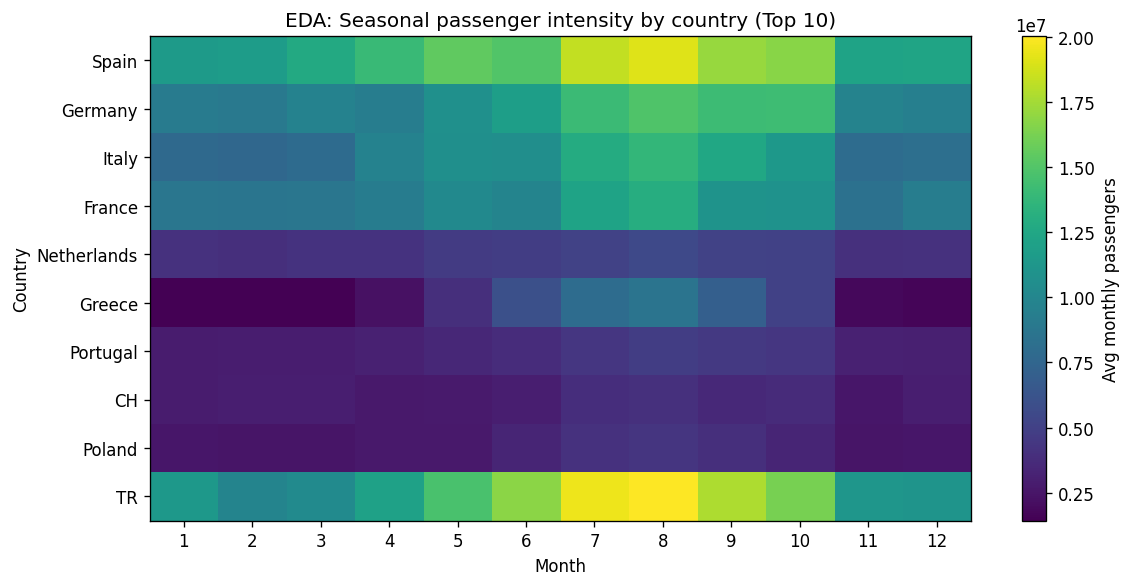

In [23]:
# ============================================================
# 11) EDA Visual 5: Seasonal intensity heatmap (top 10 countries)
# ============================================================
# I average each month-of-year per country so I can see the seasonal pattern clearly.
heat = (
    tmp_total.assign(month=tmp_total["date"].dt.month)
    .groupby(["country", "month"])["value"].mean()
    .unstack()
)

# Keep only the same top 10 countries from the bar chart for readability
heat = heat.loc[top10.index]

plt.figure(figsize=(10, 5))
plt.imshow(heat, aspect="auto")
plt.colorbar(label="Avg monthly passengers")
plt.yticks(range(len(heat.index)), heat.index)
plt.xticks(range(12), range(1, 13))
plt.title("EDA: Seasonal passenger intensity by country (Top 10)")
plt.xlabel("Month")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [24]:
# ============================================================
# 12) RQ1: Recovery speed ranking (with full country names)
#     Question: # "Which countries recovered fastest back to baseline traffic,
#  and does recovery differ between domestic (NAT) and international (INTL)?"
#
# Method:
# - baseline = mean of 2020-01 and 2020-02
# - recovery date = first month where value >= 90% of baseline for 3 consecutive months
# - rank countries by recovery month (earlier = faster)
# ============================================================
def recovery_rank(d: pd.DataFrame, meas="PAS_CRD", cov="TOTAL",
                  baseline_months=("2020-01", "2020-02"),
                  threshold=0.90, consecutive=3, min_baseline=1e5):
    x = d[(d["tra_meas"] == meas) & (d["tra_cov"] == cov)].copy()

    # country-month series (sum across schedules etc.)
    x = x.groupby(["geo", "country", "date"], as_index=False)["value"].sum()
    x = x.sort_values(["geo", "date"])

    # baseline = average of Jan-Feb 2020 (closest "normal" window in this dataset)
    base_mask = x["date"].isin(pd.to_datetime(list(baseline_months)))
    baseline = x[base_mask].groupby("geo")["value"].mean()

    # drop tiny baselines (prevents silly rankings from very small markets)
    baseline = baseline[baseline >= min_baseline]

    def first_recovery_date(g):
        b = baseline.get(g.name, np.nan)
        if not np.isfinite(b):
            return pd.NaT

        g = g.copy()
        g["ratio"] = g["value"] / b
        g = g[g["date"] >= pd.to_datetime("2020-03-01")]

        ok = (g["ratio"] >= threshold).astype(int).values
        if len(ok) < consecutive:
            return pd.NaT

        run = np.convolve(ok, np.ones(consecutive, dtype=int), mode="valid")
        idx = np.where(run == consecutive)[0]
        if len(idx) == 0:
            return pd.NaT
        return g.iloc[idx[0]]["date"]

    rec = x.groupby("geo").apply(first_recovery_date).reset_index()
    rec.columns = ["geo", "recovery_date"]

    # attach names + baseline + last known ratio (useful for countries that never "recover")
    geo_to_country = x.drop_duplicates("geo").set_index("geo")["country"]
    rec["country"] = rec["geo"].map(geo_to_country)
    rec["baseline"] = rec["geo"].map(baseline)

    last = x.groupby("geo").tail(1).set_index("geo")["value"]
    rec["last_ratio"] = rec["geo"].map(last) / rec["baseline"]

    rec = rec.sort_values(["recovery_date", "last_ratio"], ascending=[True, False])
    return rec

rec_intl = recovery_rank(analysis, meas="PAS_CRD", cov="INTL")
rec_nat  = recovery_rank(analysis, meas="PAS_CRD", cov="NAT")

display(rec_intl.head(15))
display(rec_nat.head(15))


,geo,recovery_date,country,baseline,last_ratio
10,EL,2020-07-01,Greece,1310578.0,1.137470
15,HR,2021-06-01,Croatia,201964.0,8.833767
5,CY,2021-06-01,Cyprus,452740.5,3.647414
3,BG,2021-07-01,Bulgaria,591057.0,1.396234
31,RS,2021-07-01,Serbia,419305.5,1.378687
30,RO,2021-07-01,Romania,1370795.5,1.299542
11,ES,2021-08-01,Spain,10665881.5,1.928757
21,LU,2021-08-01,Luxembourg,292469.0,1.750165
25,MT,2021-08-01,Malta,420354.0,1.727073
29,PT,2021-08-01,Portugal,3090418.5,1.149546


,geo,recovery_date,country,baseline,last_ratio
19,IT,2021-06-01,Italy,2079770.0,1.591275
10,EL,2021-06-01,Greece,529435.5,1.053522
11,ES,2021-07-01,Spain,2966894.5,1.447360
8,DK,2021-07-01,Denmark,123153.5,1.319824
29,PT,2021-07-01,Portugal,337170.0,1.133849
27,NO,2021-09-01,Norway,1201459.5,1.059630
14,FR,2022-04-01,France,2336782.0,0.925435
28,PL,2022-05-01,Poland,146629.0,1.009296
12,EU27_2007,NaT,EU27_2007,12770547.0,1.000000
36,UK,NaT,UK,1551334.0,1.000000


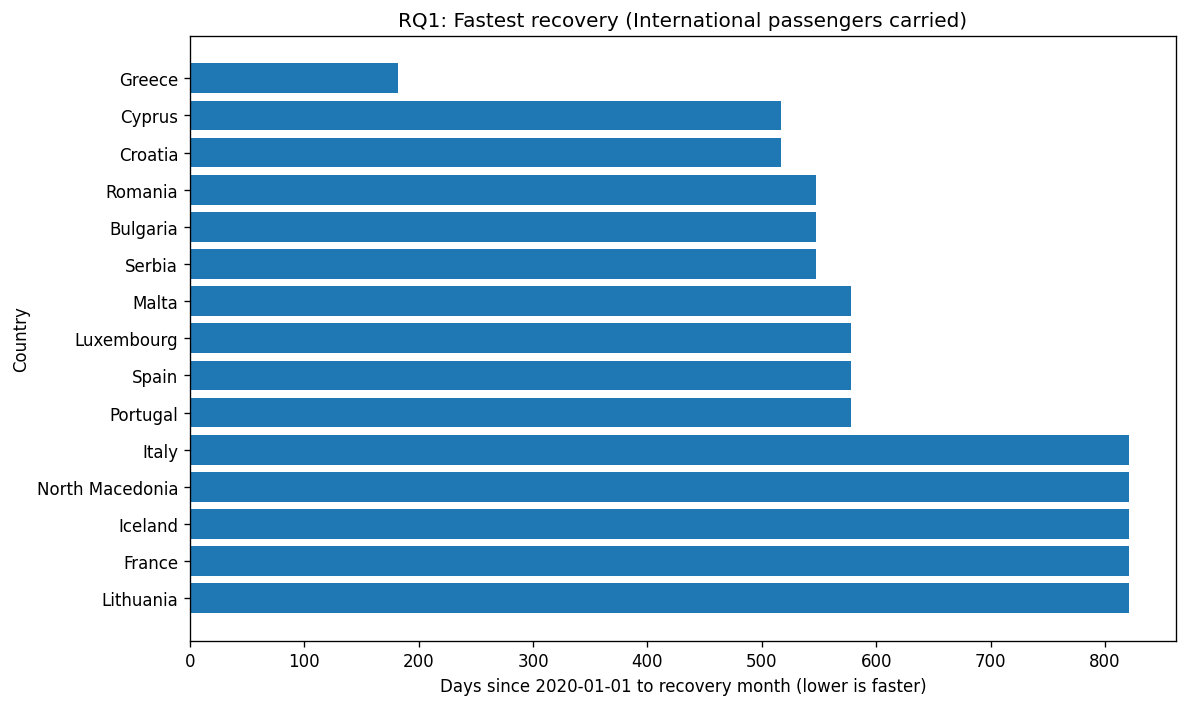

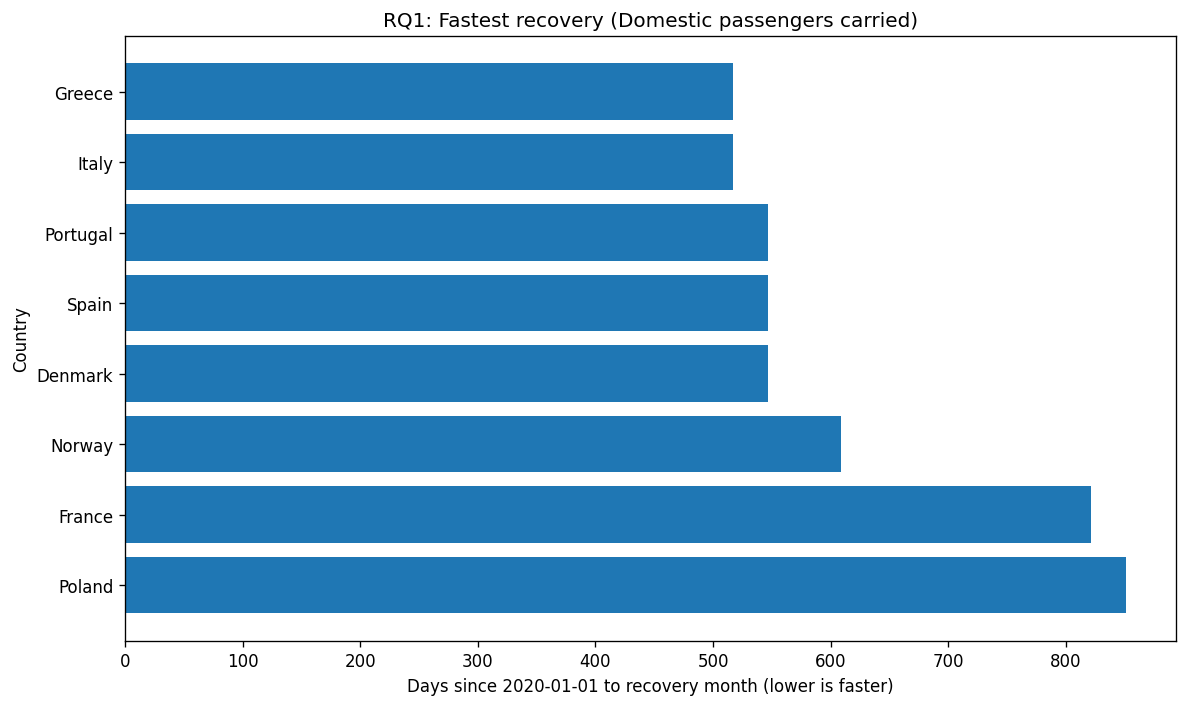

In [25]:
# ============================================================
# 13) RQ1 Visual: Recovery ranking bar chart (with full names)
# ============================================================
def plot_recovery_bar(rec: pd.DataFrame, title: str, top_n=15):
    r = rec[rec["recovery_date"].notna()].head(top_n).copy()
    if r.empty:
        print("No recoveries found with current rule (threshold/consecutive).")
        return

    # I convert recovery date into "days since 2020-01-01" for a clean numeric axis
    r["days_to_recovery"] = (r["recovery_date"] - pd.to_datetime("2020-01-01")).dt.days

    # for a nice readable order (fastest on top)
    r = r.sort_values("days_to_recovery", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(r["country"], r["days_to_recovery"])
    plt.title(title)
    plt.xlabel("Days since 2020-01-01 to recovery month (lower is faster)")
    plt.ylabel("Country")
    plt.tight_layout()
    plt.show()

plot_recovery_bar(rec_intl, "RQ1: Fastest recovery (International passengers carried)", top_n=15)
plot_recovery_bar(rec_nat,  "RQ1: Fastest recovery (Domestic passengers carried)", top_n=15)


In [31]:
# ============================================================
# 14) RQ2: Inbound vs outbound imbalance (ARR vs DEP)
#     Question: # "Did certain countries experience persistent inbound vs outbound imbalance
#  after COVID (tourism-driven asymmetry)?"
#
# Method:
# - Use passengers carried ARR vs DEP
# - Compute ARR/DEP ratio over time per country (for TOTAL and INTL separately)
# - Identify countries where imbalance persists (e.g., ratio > 1.05 for 6+ months)
# ============================================================
def imbalance_timeseries(d: pd.DataFrame, cov="TOTAL", min_monthly=2e4):
    arr = (
        d[(d["tra_meas"] == "PAS_CRD_ARR") & (d["tra_cov"] == cov)]
        .groupby(["geo", "country", "date"], as_index=False)["value"].sum()
        .rename(columns={"value": "arrivals"})
    )
    dep = (
        d[(d["tra_meas"] == "PAS_CRD_DEP") & (d["tra_cov"] == cov)]
        .groupby(["geo", "country", "date"], as_index=False)["value"].sum()
        .rename(columns={"value": "departures"})
    )

    m = pd.merge(arr, dep, on=["geo", "country", "date"], how="inner").sort_values(["geo", "date"])

    # I filter out tiny months because ratios get noisy when numbers are too small
    m = m[(m["arrivals"] >= min_monthly) & (m["departures"] >= min_monthly)].copy()

    m["arr_dep_ratio"] = m["arrivals"] / m["departures"]
    return m

imb_intl = imbalance_timeseries(analysis, cov="INTL")

def persistent_imbalance(imb: pd.DataFrame, ratio_hi=1.05, ratio_lo=0.95, months=6):
    out = []
    for geo, g in imb.groupby("geo"):
        g = g.sort_values("date")
        r = g["arr_dep_ratio"].values

        hi = (r >= ratio_hi).astype(int)
        lo = (r <= ratio_lo).astype(int)

        def max_run(a):
            maxlen, curr = 0, 0
            for v in a:
                if v == 1:
                    curr += 1
                    maxlen = max(maxlen, curr)
                else:
                    curr = 0
            return maxlen

        out.append({
            "geo": geo,
            "country": g["country"].iloc[0],
            "max_run_ratio_high": max_run(hi),
            "max_run_ratio_low": max_run(lo),
            "median_ratio": float(np.median(r)),
        })

    res = pd.DataFrame(out)
    res["persistent_inbound_heavy"] = res["max_run_ratio_high"] >= months
    res["persistent_outbound_heavy"] = res["max_run_ratio_low"] >= months
    return res.sort_values(["persistent_inbound_heavy", "max_run_ratio_high", "median_ratio"],
                           ascending=[False, False, False])

imb_summary_intl = persistent_imbalance(imb_intl, months=6)
display(imb_summary_intl.head(20))


,geo,country,max_run_ratio_high,max_run_ratio_low,median_ratio,persistent_inbound_heavy,persistent_outbound_heavy
15,HR,Croatia,5,4,1.056093,False,False
1,BA,Bosnia and Herzegovina,5,4,1.042338,False,False
5,CY,Cyprus,5,3,1.019042,False,False
23,ME,Montenegro,5,4,1.018738,False,False
10,EL,Greece,5,4,0.943521,False,False
14,FR,France,4,2,1.035466,False,False
7,DE,Germany,4,3,1.021936,False,False
29,PT,Portugal,3,3,1.026327,False,False
11,ES,Spain,3,2,1.022735,False,False
26,NL,Netherlands,3,2,1.018508,False,False


Countries in ratio_summary: 37


,country,arr_dep_ratio
36,UK,1.094196
5,Croatia,1.056093
2,Bosnia and Herzegovina,1.042338
12,France,1.035466
28,Portugal,1.026327
33,Spain,1.022735
26,Norway,1.021995
13,Germany,1.021936
6,Cyprus,1.019042
23,Montenegro,1.018738


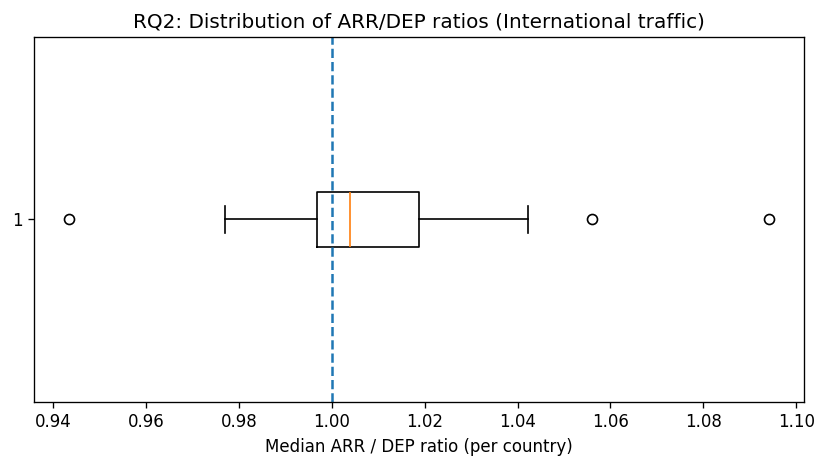

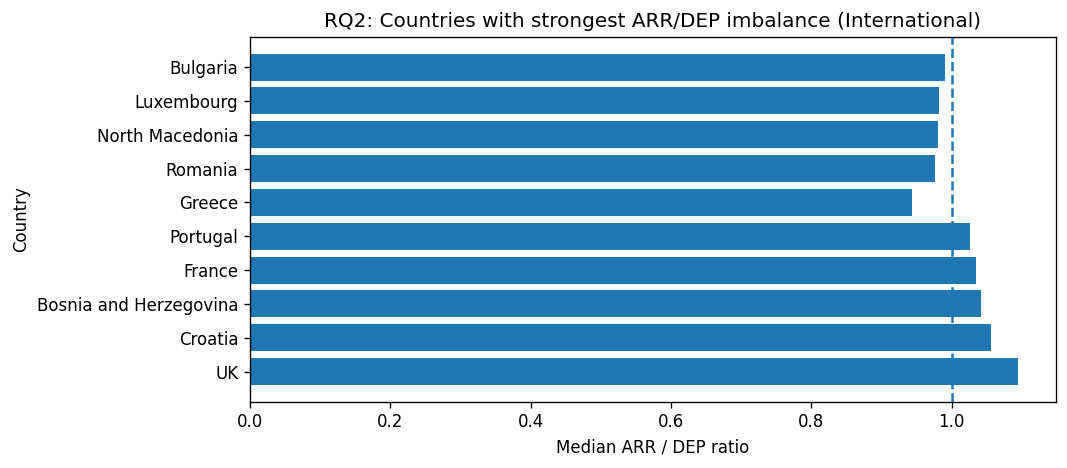

In [35]:
# ============================================================
# 15)
# RQ2 Visual 2: Most inbound-heavy vs outbound-heavy countries
# ============================================================
ratio_summary = (
    imb_intl
    .groupby("country")["arr_dep_ratio"]
    .median()
    .reset_index()
    .sort_values("arr_dep_ratio", ascending=False)
)

print("Countries in ratio_summary:", len(ratio_summary))
display(ratio_summary.head(10))

plt.figure(figsize=(7, 4))
plt.boxplot(ratio_summary["arr_dep_ratio"], vert=False)
plt.axvline(1.0, linestyle="--")
plt.title("RQ2: Distribution of ARR/DEP ratios (International traffic)")
plt.xlabel("Median ARR / DEP ratio (per country)")
plt.tight_layout()
plt.show()

top_inbound = ratio_summary.sort_values("arr_dep_ratio", ascending=False).head(5)
top_outbound = ratio_summary.sort_values("arr_dep_ratio", ascending=True).head(5)

combined = pd.concat([top_inbound, top_outbound])

plt.figure(figsize=(9, 4))
plt.barh(combined["country"], combined["arr_dep_ratio"])
plt.axvline(1.0, linestyle="--")
plt.title("RQ2: Countries with strongest ARR/DEP imbalance (International)")
plt.xlabel("Median ARR / DEP ratio")
plt.ylabel("Country")
plt.tight_layout()
plt.show()



In [28]:
# ============================================================
# 16) RQ3: Seasonality change using STL decomposition
#     Question: # "Did seasonality strength change after the pandemic disruption?"
#
# Method:
# - For each country, use STL decomposition on monthly TOTAL passengers carried (PAS_CRD)
# - Compare seasonal amplitude post-2022 vs 2020-2021
# - Rank countries by increase/decrease in seasonality
# ============================================================
def stl_seasonality_change(d: pd.DataFrame, cov="TOTAL", meas="PAS_CRD"):
    x = (
        d[(d["tra_cov"] == cov) & (d["tra_meas"] == meas)]
        .groupby(["geo", "country", "date"], as_index=False)["value"].sum()
        .sort_values(["geo", "date"])
    )

    out = []
    for geo, g in x.groupby("geo"):
        country = g["country"].iloc[0]
        series = g.set_index("date")["value"].asfreq("MS")

        # I need enough data for seasonality (at least ~3 years)
        if series.notna().sum() < 36:
            continue

        # I only interpolate small gaps for decomposition (and I'd mention this in limitations)
        s_i = series.interpolate(limit=3)

        try:
            stl = STL(s_i, period=12, robust=True).fit()
        except Exception:
            continue

        seasonal = stl.seasonal

        def amp(s):
            # robust amplitude: 95th - 5th percentile (less sensitive to spikes)
            return float(np.nanpercentile(s, 95) - np.nanpercentile(s, 5))

        pre = seasonal[(seasonal.index >= "2020-01-01") & (seasonal.index <= "2021-12-01")]
        post = seasonal[(seasonal.index >= "2022-01-01") & (seasonal.index <= seasonal.index.max())]

        if pre.notna().sum() < 12 or post.notna().sum() < 12:
            continue

        pre_amp = amp(pre)
        post_amp = amp(post)

        out.append({
            "geo": geo,
            "country": country,
            "season_amp_2020_2021": pre_amp,
            "season_amp_2022_plus": post_amp,
            "amp_change": post_amp - pre_amp,
            "amp_change_pct": (post_amp - pre_amp) / pre_amp if pre_amp != 0 else np.nan
        })

    res = pd.DataFrame(out).sort_values("amp_change_pct", ascending=False)
    return res

season_change = stl_seasonality_change(analysis)
display(season_change.head(20))


,geo,country,season_amp_2020_2021,season_amp_2022_plus,amp_change,amp_change_pct
22,ME,Montenegro,1.262028e+05,2.736904e+05,1.474876e+05,1.168655
33,SK,Slovakia,1.577421e+05,2.882532e+05,1.305111e+05,0.827370
14,HR,Croatia,9.756479e+05,1.723415e+06,7.477669e+05,0.766431
5,CY,Cyprus,6.436416e+05,9.917859e+05,3.481443e+05,0.540898
18,IT,Italy,6.057968e+06,8.428219e+06,2.370251e+06,0.391262
6,CZ,Czechia,7.694250e+05,1.058639e+06,2.892138e+05,0.375883
1,BA,Bosnia and Herzegovina,1.357781e+05,1.848381e+05,4.906001e+04,0.361325
10,EL,Greece,6.699566e+06,8.879752e+06,2.180186e+06,0.325422
27,PL,Poland,2.130137e+06,2.487507e+06,3.573702e+05,0.167769
23,MK,North Macedonia,1.587440e+05,1.849088e+05,2.616481e+04,0.164824


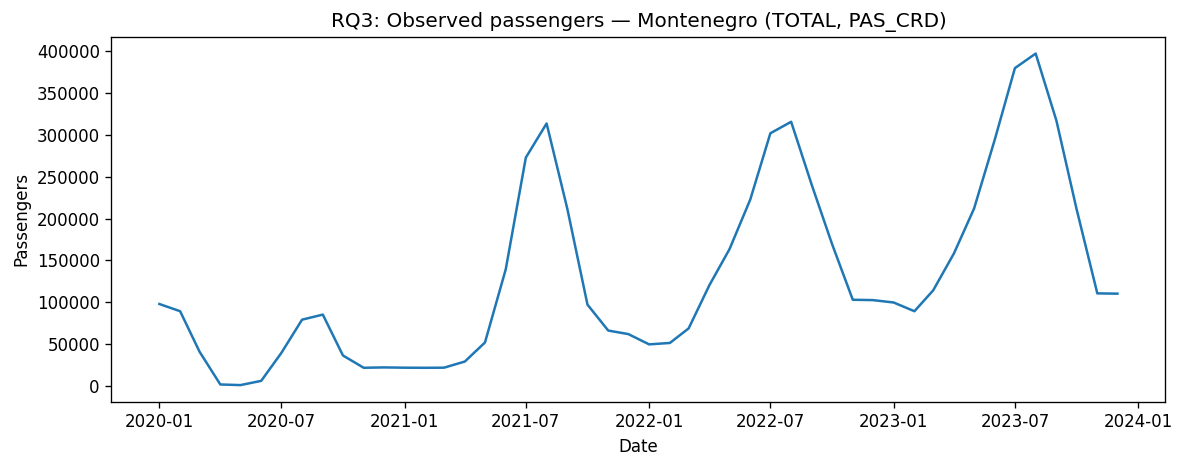

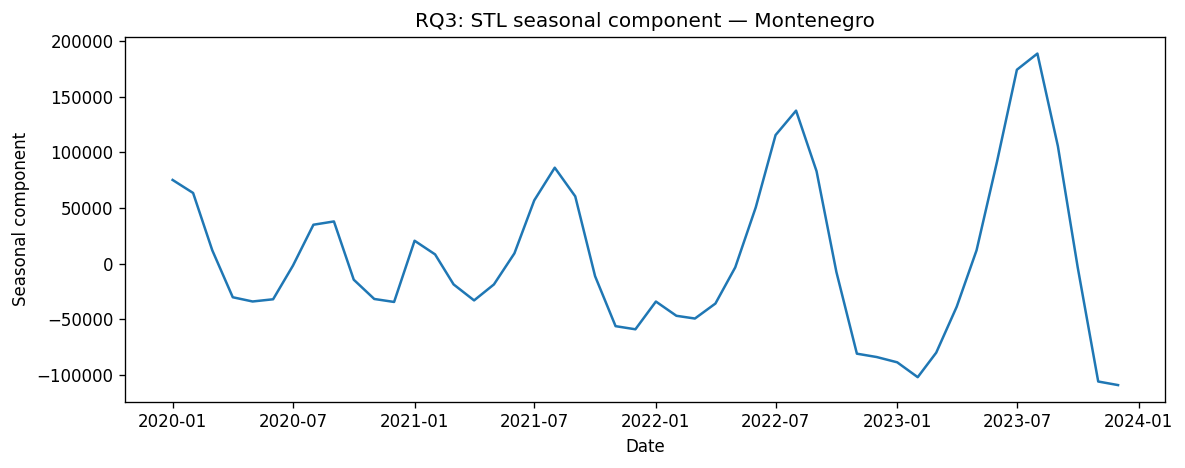

In [29]:
# ============================================================
# 17) RQ3 Visual: Observed + seasonal component for one country
# ============================================================
def plot_stl_example(d: pd.DataFrame, country_name: str, cov="TOTAL", meas="PAS_CRD"):
    x = (
        d[(d["tra_cov"] == cov) & (d["tra_meas"] == meas)]
        .groupby(["country", "date"], as_index=False)["value"].sum()
        .sort_values(["country", "date"])
    )

    g = x[x["country"] == country_name].set_index("date")["value"].asfreq("MS")
    if g.notna().sum() < 24:
        print("Not enough data for STL plot:", country_name)
        return

    g_i = g.interpolate(limit=3)
    stl = STL(g_i, period=12, robust=True).fit()

    plt.figure(figsize=(10, 4))
    plt.plot(g.index, g.values)
    plt.title(f"RQ3: Observed passengers — {country_name} ({cov}, {meas})")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(stl.seasonal.index, stl.seasonal.values)
    plt.title(f"RQ3: STL seasonal component — {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Seasonal component")
    plt.tight_layout()
    plt.show()

# Example: plot the top-ranked country in seasonality change
if not season_change.empty:
    plot_stl_example(analysis, season_change.iloc[0]["country"])


In [30]:
# ============================================================
# 18) Save outputs for appendix (optional but helpful)
# ============================================================
os.makedirs("outputs", exist_ok=True)

rec_intl.to_csv("outputs/RQ1_recovery_INTL.csv", index=False)
rec_nat.to_csv("outputs/RQ1_recovery_NAT.csv", index=False)

imb_summary_intl.to_csv("outputs/RQ2_imbalance_INTL_summary.csv", index=False)
season_change.to_csv("outputs/RQ3_seasonality_change.csv", index=False)

print("Saved tables to ./outputs/")


Saved tables to ./outputs/
